# Deep Reinforcement Learning (PPO Implementation)

Implementing Proximal Policy Optimization (PPO) for trading on the stock market involves several steps. Which includes creating the environment, implementing PPO, training the model, and plotting the results

### Imports

In [12]:
import yfinance as yf
import pandas as pd

# Fetch historical data for Apple Inc.
data = yf.download('AAPL', start='2020-01-01', end='2023-01-01')
data = data[['Close']]  # Use only the closing price for simplicity
data.reset_index(inplace=True)


[*********************100%%**********************]  1 of 1 completed


### The Environment

In [13]:
import gym
from gym import spaces
import numpy as np

class TradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000):
        super(TradingEnv, self).__init__()
        self.data = data
        self.initial_balance = initial_balance
        self.action_space = spaces.Discrete(3)  # Actions: 0 = Hold, 1 = Buy, 2 = Sell
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(3,), dtype=np.float32)
        self.reset()

    def reset(self):
        self.balance = self.initial_balance
        self.stock_held = 0
        self.current_step = 0
        self.done = False
        return self._get_state()

    def _get_state(self):
        return np.array([self.balance, self.stock_held, self.data.iloc[self.current_step]['Close']], dtype=np.float32)

    def step(self, action):
        current_price = self.data.iloc[self.current_step]['Close']
        self.current_step += 1

        if action == 0:  # Hold
            reward = 0
        elif action == 1:  # Buy
            if self.balance >= current_price:
                self.stock_held += 1
                self.balance -= current_price
                reward = 0
            else:
                reward = -1  # Penalty for trying to buy without enough balance
        elif action == 2:  # Sell
            if self.stock_held > 0:
                self.stock_held -= 1
                self.balance += current_price
                reward = current_price - self.data.iloc[self.current_step-1]['Close']  # Reward is profit from the sale
            else:
                reward = -1  # Penalty for trying to sell without holding any stock

        if self.current_step >= len(self.data) - 1:
            self.done = True
        else:
            self.done = False

        next_state = self._get_state()
        return next_state, reward, self.done, {}

env = TradingEnv(data)


In [14]:
!pip install tensorflow

#Implement PPO
PPO involves defining the actor and critic networks, the loss function, and the training loop. We'll use TensorFlow and Keras for this.

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp

class PPOAgent:
    def __init__(self, state_size, action_size, learning_rate=0.0003, gamma=0.99, epsilon=0.2, beta=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.beta = beta
        self.actor, self.critic = self._build_model()

    def _build_model(self):
        inputs = Input(shape=(self.state_size,))
        dense1 = Dense(64, activation='relu')(inputs)
        dense2 = Dense(64, activation='relu')(dense1)

        action_probs = Dense(self.action_size, activation='softmax')(dense2)
        values = Dense(1, activation='linear')(dense2)

        actor = Model(inputs, action_probs)
        critic = Model(inputs, values)

        actor.compile(optimizer=Adam(learning_rate=self.learning_rate), loss=self._actor_loss)
        critic.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')

        return actor, critic

    def _actor_loss(self, y_true, y_pred):
        advantages, actions, old_predictions = y_true[:, :1], y_true[:, 1:1+self.action_size], y_true[:, 1+self.action_size:]

        new_policy = tf.reduce_sum(actions * y_pred, axis=1, keepdims=True)
        old_policy = tf.reduce_sum(actions * old_predictions, axis=1, keepdims=True)

        ratio = new_policy / (old_policy + 1e-10)

        surrogate1 = ratio * advantages
        surrogate2 = tf.clip_by_value(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantages

        loss = -tf.reduce_mean(tf.minimum(surrogate1, surrogate2))
        entropy = -tf.reduce_mean(y_pred * tf.math.log(y_pred + 1e-10))

        return loss - self.beta * entropy

    def act(self, state):
        state = state.reshape([1, self.state_size])
        action_probs = self.actor.predict(state, verbose=0)[0]
        action = np.random.choice(self.action_size, p=action_probs)
        return action, action_probs

    def train(self, states, actions, rewards, next_states, dones):
        actions = tf.one_hot(actions, self.action_size)

        old_predictions = self.actor.predict(states, verbose=0)
        values = self.critic.predict(states, verbose=0)
        next_values = self.critic.predict(next_states, verbose=0)

        advantages = rewards + self.gamma * (1 - dones) * next_values.squeeze() - values.squeeze()
        advantages = advantages.reshape([-1, 1])

        y_true = np.hstack([advantages, actions, old_predictions])

        self.actor.train_on_batch(states, y_true)
        self.critic.train_on_batch(states, rewards + self.gamma * (1 - dones) * next_values.squeeze())



Episode 1/10, Total Reward: -621.0
Episode 2/10, Total Reward: -621.0
Episode 3/10, Total Reward: -621.0
Episode 4/10, Total Reward: -490.0
Episode 5/10, Total Reward: 0.0
Episode 6/10, Total Reward: 0.0
Episode 7/10, Total Reward: 0.0
Episode 8/10, Total Reward: -755
Episode 9/10, Total Reward: -755
Episode 10/10, Total Reward: -755


NameError: name 'plt' is not defined

# Training Function

In [7]:
# Training Function
def train_ppo(agent, env, num_episodes, batch_size):
    rewards = []
    for e in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False

        states, actions, rewards_list, next_states, dones = [], [], [], [], []

        while not done:
            action, action_prob = agent.act(state)
            next_state, reward, done, _ = env.step(action)

            states.append(state)
            actions.append(action)
            rewards_list.append(reward)
            next_states.append(next_state)
            dones.append(done)

            state = next_state
            episode_reward += reward

            if len(states) >= batch_size:
                agent.train(np.array(states), np.array(actions), np.array(rewards_list), np.array(next_states), np.array(dones))
                states, actions, rewards_list, next_states, dones = [], [], [], [], []

        rewards.append(episode_reward)
        print(f"Episode {e+1}/{num_episodes}, Total Reward: {episode_reward}")

    return rewards

# Parameters
num_episodes = 10
state_size = 3
action_size = 3
batch_size = 32

# Train PPO Agent
ppo_agent = PPOAgent(state_size, action_size)
ppo_rewards = train_ppo(ppo_agent, env, num_episodes, batch_size)


Episode 1/10, Total Reward: -755
Episode 2/10, Total Reward: -755
Episode 3/10, Total Reward: -755
Episode 4/10, Total Reward: -755
Episode 5/10, Total Reward: -755
Episode 6/10, Total Reward: -755
Episode 7/10, Total Reward: -755
Episode 8/10, Total Reward: -755
Episode 9/10, Total Reward: -755
Episode 10/10, Total Reward: -755


# Plotting the Results

In [16]:
!pip install matplotlib

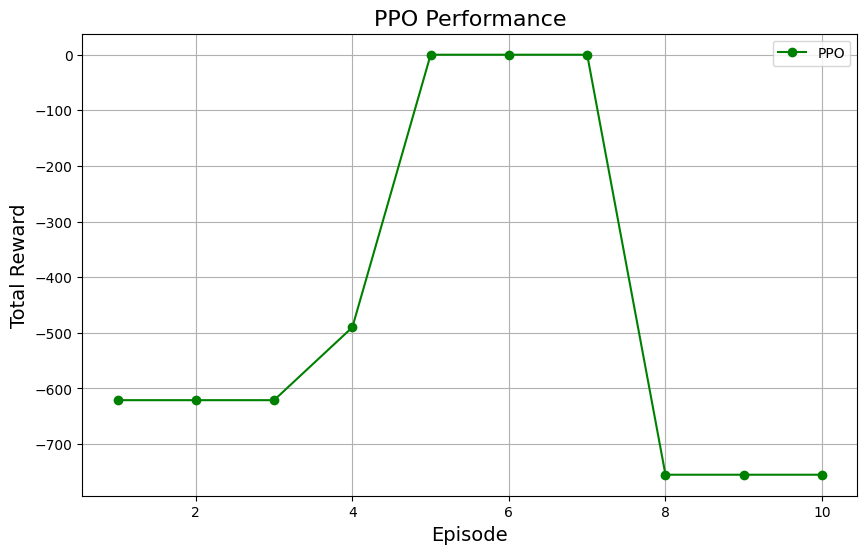

In [17]:
import matplotlib.pyplot as plt

def plot_rewards(ppo_rewards):
    episodes = range(1, len(ppo_rewards) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(episodes, ppo_rewards, label='PPO', marker='o', linestyle='-', color='g')

    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Total Reward', fontsize=14)
    plt.title('PPO Performance', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_rewards(ppo_rewards)
